In [1]:
# https://www.kaggle.com/datasets/pranavraikokte/covid19-image-dataset

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
import numpy

In [41]:
# creating ImageDataGenerator object 
training_generator = ImageDataGenerator(rescale=1.0/255, zoom_range=0.1, rotation_range=25, width_shift_range=0.05, height_shift_range=0.05)
training_iterator = training_generator.flow_from_directory("Covid19-dataset/train",class_mode='categorical',color_mode='grayscale',batch_size=32)

validation_generator = ImageDataGenerator()
validation_iterator = validation_generator.flow_from_directory("Covid19-dataset/test",class_mode='categorical',color_mode='grayscale',batch_size=32)



Found 251 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


In [43]:
# creating a model that takes our image data as an input and outputs 3 classes
model = tf.keras.Sequential()
model.add(tf.keras.Input(shape = (256, 256, 1)))
model.add(tf.keras.layers.Conv2D(5, 5, strides = 2, activation = 'relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = (2,2)))
model.add(layers.Dropout(0.1))
model.add(tf.keras.layers.Conv2D(3, 3, strides = 1))
model.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = (2,2)))
model.add(layers.Dropout(0.2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(3, activation = 'softmax'))
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = tf.keras.losses.CategoricalCrossentropy(), metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.AUC()])
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 126, 126, 5)    │           130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 63, 63, 5)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 63, 63, 5)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 61, 61, 3)      │           138 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 30, 30, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 30, 30, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2700)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         8,103 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,371 (32.70 KB)

 Trainable params: 8,371 (32.70 KB)

 Non-trainable params: 0 (0.00 B)

In [45]:
# implementing an early stopping mechanism 
stopping = EarlyStopping(monitor='val_auc', mode='min', verbose=1, patience=20)
steps_per_epoch = int(training_iterator.samples / 32.0)
validation_steps = int(validation_iterator.samples / 32.0)


In [59]:
# fitting the model 
history = model.fit(
    training_iterator,
    steps_per_epoch=steps_per_epoch,
    epochs=4,
    validation_data=validation_iterator,
    validation_steps=validation_steps,
    callbacks=[stopping]
)

Epoch 1/4
7/7 ━━━━━━━━━━━━━━━━━━━━ 26s 4s/step - auc_1: 0.9397 - categorical_accuracy: 0.8276 - loss: 0.4686 - val_auc_1: 0.8242 - val_categorical_accuracy: 0.7656 - val_loss: 75.4522
Epoch 2/4
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 419ms/step - auc_1: 0.9487 - categorical_accuracy: 0.8438 - loss: 0.4074 - val_auc_1: 0.8242 - val_categorical_accuracy: 0.7656 - val_loss: 75.1020
Epoch 3/4
7/7 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - auc_1: 0.9480 - categorical_accuracy: 0.8211 - loss: 0.4252 - val_auc_1: 0.8477 - val_categorical_accuracy: 0.7969 - val_loss: 96.7219
Epoch 4/4
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 443ms/step - auc_1: 0.9756 - categorical_accuracy: 0.9062 - loss: 0.2894 - val_auc_1: 0.8594 - val_categorical_accuracy: 0.8125 - val_loss: 78.1434


In [61]:
# confusion matrix 
import math
test_steps_per_epoch = math.ceil(validation_iterator.samples / validation_iterator.batch_size)
predictions = model.predict(validation_iterator, steps=test_steps_per_epoch)
predicted_classes = numpy.argmax(predictions, axis=1)
true_classes = validation_iterator.classes
confusion_matrix(true_classes,predicted_classes)


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 878ms/step


array([[13,  9,  4],
       [ 4, 12,  4],
       [ 5, 10,  5]], dtype=int64)

In [75]:
print(history.history.keys())

dict_keys(['auc_1', 'categorical_accuracy', 'loss', 'val_auc_1', 'val_categorical_accuracy', 'val_loss'])


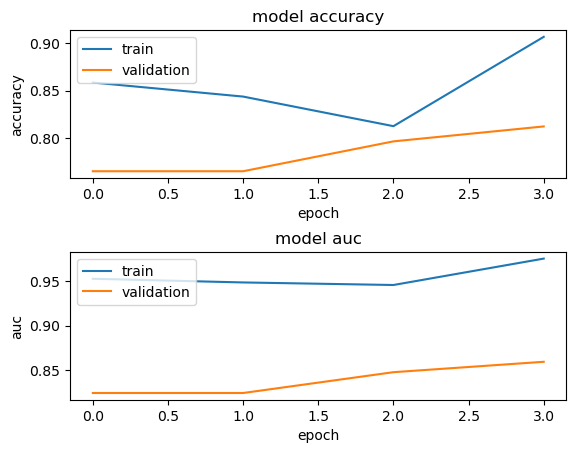

In [73]:
# visualizing model's accuracy and AUC metrics
import matplotlib.pyplot as plt
fig = plt.figure()
ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(history.history['categorical_accuracy'])
ax1.plot(history.history['val_categorical_accuracy'])
ax1.set_title('model accuracy')
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')
ax1.legend(['train', 'validation'], loc='upper left')

# plotting auc and validation auc over epochs
ax2 = fig.add_subplot(2, 1, 2)
ax2.plot(history.history['auc_1'])
ax2.plot(history.history['val_auc_1'])
ax2.set_title('model auc')
ax2.set_xlabel('epoch')
ax2.set_ylabel('auc')
ax2.legend(['train', 'validation'], loc='upper left')
plt.subplots_adjust(hspace=0.5)
plt.show()